Acknowledge that the dataset herein is miniature and can be toyed with on Jupyter nb using a local machine, perhaps with single GPU. More realistic datasets would require API interfacing with a cluster and data engineering pipelines to display distributions of billions of params over time, or to run robust imputation methods for missing data as standalone endeavors before one even considers modeling.


In [159]:
import pandas as pd
import numpy as np

In [160]:
data = pd.read_csv("../data/train_sparked.csv")
X_test_nulls_raw = pd.read_csv("../data/test_sparked.csv")

In [161]:
data

,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehCertified,VehColorExt,...,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehYear,Vehicle_Trim,Dealer_Listing_Price,NumOwners
0,warren,False,inventorycommandcenter,primemotorz,5.0,32,MI,48091,False,white,...,8.600069,Jeep,39319,grandcherokee,fairprice,None.,2015,High Altitude,30990.0,1.0
1,fargo,False,cadillaccertifiedprogram,gatewaychevroletcadillac,4.8,1456,ND,58103,True,black,...,2.920127,Cadillac,30352,xt5,gooddeal,Come take a look at our great pre-owned invent...,2017,NaN,34860.0,1.0
2,waukesha,False,jeepcertifiedprogram,wildechryslerjeepdodgeramampsubaru,4.8,1405,WI,53186,True,brilliantblackcrystalpearlcoat,...,28.107014,Jeep,38957,grandcherokee,gooddeal,Backed by a rigorous 125-point inspection by f...,2015,Laredo,23249.0,1.0
3,wentzville,False,inventorycommandcenter,centurydodgechryslerjeepram,4.4,21,MO,63385,False,diamondblackcrystalpearlcoat,...,59.816875,Jeep,20404,grandcherokee,gooddeal,Drop by to see us and you will quickly see how...,2018,Limited,31977.0,1.0
4,fayetteville,False,homenetautomotive,superiorbuickgmcoffayetteville,3.7,74,AR,72703,False,radiantsilvermetallic,...,98.665301,Cadillac,19788,xt5,gooddeal,"Luxury, Exterior Parking Camera Rear, Front Du...",2018,Luxury,33495.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6289,dearborn,True,sellityourself,abe,0.0,0,MI,48126,False,black,...,29.781968,Jeep,49000,grandcherokee,NaN,****ALL BLACK EDITION****You are viewing a bea...,2015,High Altitude,18699.0,NaN
6290,indianapolis,False,digitalmotorworksdmi,carmaxindianapolis,3.3,16,IN,46280,False,gray,...,4.840069,Jeep,20039,grandcherokee,fairprice,CarMax makes car buying easy and hassle-free. ...,2015,Limited,31998.0,1.0
6291,dublin,False,digitalmotorworksdmi,cadillacofdublin,4.1,20,OH,43017,True,black,...,184.921991,Cadillac,16278,xt5,gooddeal,Clean CARFAX. Certified. Black 2018 Cadillac X...,2018,Luxury,35674.0,0.0
6292,sandusky,False,digitalmotorworksdmi,fosterchevroletcadillac,4.9,278,OH,44870,False,black,...,73.868426,Cadillac,38146,xt5,greatdeal,Black 2017 Cadillac XT5 Luxury FWD 8-Speed Aut...,2017,Luxury,31995.0,2.0


In [162]:
data.dtypes

SellerCity               object
SellerIsPriv               bool
SellerListSrc            object
SellerName               object
SellerRating            float64
SellerRevCnt              int64
SellerState              object
SellerZip                 int64
VehCertified               bool
VehColorExt              object
VehColorInt              object
VehDriveTrain            object
VehEngine                object
VehFeats                 object
VehFuel                  object
VehHistory               object
VehListdays             float64
VehMake                  object
VehMileage                int64
VehModel                 object
VehPriceLabel            object
VehSellerNotes           object
VehYear                   int64
Vehicle_Trim             object
Dealer_Listing_Price    float64
NumOwners               float64
dtype: object

In [163]:
data.dtypes

SellerCity               object
SellerIsPriv               bool
SellerListSrc            object
SellerName               object
SellerRating            float64
SellerRevCnt              int64
SellerState              object
SellerZip                 int64
VehCertified               bool
VehColorExt              object
VehColorInt              object
VehDriveTrain            object
VehEngine                object
VehFeats                 object
VehFuel                  object
VehHistory               object
VehListdays             float64
VehMake                  object
VehMileage                int64
VehModel                 object
VehPriceLabel            object
VehSellerNotes           object
VehYear                   int64
Vehicle_Trim             object
Dealer_Listing_Price    float64
NumOwners               float64
dtype: object

In [164]:
X_test_nulls_raw

,ListingID,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehCertified,...,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehYear,NumOwners
0,8622015,seneca,False,homenetautomotive,lakekeoweechryslerdodgejeepram,2.5,59,SC,29678,False,...,Gasoline,"['non-personal use reported', 'buyback protect...",143.991262,Cadillac,13625.0,xt5,gooddeal,Thank you for visiting another one of Lake Keo...,2018,1.0
1,8625693,bedford,False,inventorycommandcenter,northcoastautomall,4.7,2116,OH,44146,False,...,Gasoline,"['accident(s) reported', 'non-personal use rep...",138.770486,Jeep,42553.0,grandcherokee,gooddeal,This 2017 Jeep Grand Cherokee 4dr Limited 4x4 ...,2017,1.0
2,8625750,webster,False,jeepcertifiedprogram,marinachryslerdodgejeepmitsubishiram,3.9,46,NY,14580,True,...,E85 Flex Fuel,['buyback protection eligible'],31.951088,Jeep,48951.0,grandcherokee,gooddeal,Certified. Brilliant Black Crystal Pearlcoat 2...,2015,1.0
3,8626885,louisville,False,digitalmotorworksdmi,oxmoorfordlincoln,4.5,1075,KY,40222,False,...,Gasoline,['buyback protection eligible'],5.950127,Jeep,44179.0,grandcherokee,gooddeal,2015 Jeep Grand Cherokee ***THIS VEHICLE IS AT...,2015,1.0
4,8627430,palmyra,False,digitalmotorworksdmi,fckerbeckampsons,4.6,162,NJ,8065,False,...,Gasoline,"['non-personal use reported', 'buyback protect...",24.672986,Cadillac,22269.0,xt5,gooddeal,"AWD, CarFax One Owner! Navigation, Back-up Cam...",2018,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9992442,forestpark,False,homenetautomotive,curriechevy,4.8,1081,IL,60130,False,...,Gasoline,['buyback protection eligible'],18.091597,Jeep,24744.0,grandcherokee,gooddeal,granite crystal metallic clearcoat 2017 Jeep G...,2017,1.0
996,9993562,tampa,False,inventorycommandcenter,tampamitsubishi,4.0,240,FL,33614,False,...,Gasoline,"['non-personal use reported', 'buyback protect...",167.799676,Cadillac,5699.0,xt5,gooddeal,Tampa Mitsubishi is proud to offer this attrac...,2017,1.0
997,9994646,tampa,False,homenetautomotive,fermanacura,5.0,134,FL,33612,False,...,Gasoline,"['accident(s) reported', 'non-personal use rep...",46.215625,Cadillac,17985.0,xt5,gooddeal,*BRAND NEW* *2018* *CADILLAC* *XT5** LOADED WI...,2018,1.0
998,9997199,hamburg,False,inventorycommandcenter,townechryslerdodgejeepraminc,3.8,7,NY,14075,False,...,Diesel,['buyback protection eligible'],14.907535,Jeep,27.0,grandcherokee,fairprice,"Thousand?s of Vehicles, Positively Different E...",2018,1.0


In [165]:
y_train_nulls = data[["Dealer_Listing_Price", "Vehicle_Trim"]]
# y_train_null_id = y_train_nulls[data.isnull().any(axis=1)].index


X_train_nulls_raw = data.drop(
    ["Dealer_Listing_Price", "Vehicle_Trim"], axis=1
)  # nulls to indicate nulls present and raw to indicate ft are not numerically encoded yet
y_test_id_nulls_raw = X_test_nulls_raw["ListingID"]  # save for later
X_test_nulls_raw = X_test_nulls_raw.drop(["ListingID"], axis=1)

We note some features that only have two options and are binarized. Recall that OrdinalEncoder is suitable for categorical variables with a meaningful order. OneHotEncoder is suitable for categorical variables without a natural specific order and can be used to binarize. Seller rating is tricky to deal with as it's a numeric categorical feature as ratings are still an ordinal measure (what does 3.5 rating - 2.0 vs 1.0 + 5.0 rating even mean??) Before we tend to these pipelines simplify the codification of ext/int colors as there is a lot of repetition.


In [166]:
# Words to match and replace with the corresponding color name
colors_to_replace = [
    "blue",
    "red",
    "black",
    "silver",
    "white",
    "cashmere",
    "steel",
    "granite",
    "ivory",
    "amethyst",
    "green",
    "gray",
    "brown",
    "bronze",
    "auburn",
    "sangria",
    "mocha",
    "rhino",
]

# Constructing a regular expression pattern to match any portion containing the specified colors
pattern = "|".join(colors_to_replace)

# Replace any portion of the string containing 'blue', 'red', or 'black' etc with only the corresponding color name
# The r'\1' in the value parameter is a backreference to the matched portion, so it replaces the entire string with only the color name.
X_train_nulls_raw["VehColorExt"] = X_train_nulls_raw["VehColorExt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)
X_test_nulls_raw["VehColorExt"] = X_test_nulls_raw["VehColorExt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)

print(
    X_train_nulls_raw["VehColorExt"].unique(),
    len(X_train_nulls_raw["VehColorExt"].unique()),
)
print(
    X_test_nulls_raw["VehColorExt"].unique(),
    len(X_test_nulls_raw["VehColorExt"].unique()),
)

['white' 'black' 'silver' 'blue' 'red' 'granite' 'gray' 'brown' 'steel'
 'charcoal' 'velvet' 'green' 'bronze' 'rhino' nan 'ivory' 'amethyst'
 'sangria' 'maroon' 'cashmere' 'certifiedhemilthrpanoroofnav' 'purple'
 'certifiedlthrroofnavcamera' 'burgundy' 'auburn' 'gold' 'grey' 'pearl'
 'diamond' 'other' 'midnightsky' 'beige' 'tan' 'notspecified'
 'certifiedlthrpanoroofnavcamera' 'platinum' 'pewter' 'mocha'
 'shadowmetallic' 'gy' 'certifiedlthrpanoroofhotcoldseats' 'pink' 'billet'
 'certifiedroofcamerahtdseats' 'beigh' 'midnightskymetallic' 'unspecified'
 'brightsil'] 48
['black' 'blue' 'granite' 'silver' 'white' nan 'red' 'beige' 'amethyst'
 'gray' 'ivory' 'billet' 'rhino' 'deepcherry' 'sangria' 'bronze' 'green'
 'velvet' 'steel' 'cashmere' 'brown' 'auburn' 'grey' 'midnightsky'
 'burgundy' 'shadowmetallic' 'tan' 'notspecified' 'diamond' 'undetermined'
 'mocha'] 31


In [167]:
X_train_nulls_raw["VehColorInt"] = X_train_nulls_raw["VehColorInt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)
X_test_nulls_raw["VehColorInt"] = X_test_nulls_raw["VehColorInt"].replace(
    to_replace=f".*({pattern}).*", value=r"\1", regex=True
)

print(
    X_train_nulls_raw["VehColorExt"].unique(),
    len(X_train_nulls_raw["VehColorInt"].unique()),
)
print(
    X_test_nulls_raw["VehColorExt"].unique(),
    len(X_test_nulls_raw["VehColorInt"].unique()),
)

# Careful not to overreach and drop colors you do not see in the test set as it's meant to be beyond our purview. This was simply to cut down on complexity

['white' 'black' 'silver' 'blue' 'red' 'granite' 'gray' 'brown' 'steel'
 'charcoal' 'velvet' 'green' 'bronze' 'rhino' nan 'ivory' 'amethyst'
 'sangria' 'maroon' 'cashmere' 'certifiedhemilthrpanoroofnav' 'purple'
 'certifiedlthrroofnavcamera' 'burgundy' 'auburn' 'gold' 'grey' 'pearl'
 'diamond' 'other' 'midnightsky' 'beige' 'tan' 'notspecified'
 'certifiedlthrpanoroofnavcamera' 'platinum' 'pewter' 'mocha'
 'shadowmetallic' 'gy' 'certifiedlthrpanoroofhotcoldseats' 'pink' 'billet'
 'certifiedroofcamerahtdseats' 'beigh' 'midnightskymetallic' 'unspecified'
 'brightsil'] 38
['black' 'blue' 'granite' 'silver' 'white' nan 'red' 'beige' 'amethyst'
 'gray' 'ivory' 'billet' 'rhino' 'deepcherry' 'sangria' 'bronze' 'green'
 'velvet' 'steel' 'cashmere' 'brown' 'auburn' 'grey' 'midnightsky'
 'burgundy' 'shadowmetallic' 'tan' 'notspecified' 'diamond' 'undetermined'
 'mocha'] 22


In [168]:
X_train_nulls_raw.columns, X_train_nulls_raw.shape, X_test_nulls_raw.shape

(Index(['SellerCity', 'SellerIsPriv', 'SellerListSrc', 'SellerName',
        'SellerRating', 'SellerRevCnt', 'SellerState', 'SellerZip',
        'VehCertified', 'VehColorExt', 'VehColorInt', 'VehDriveTrain',
        'VehEngine', 'VehFeats', 'VehFuel', 'VehHistory', 'VehListdays',
        'VehMake', 'VehMileage', 'VehModel', 'VehPriceLabel', 'VehSellerNotes',
        'VehYear', 'NumOwners'],
       dtype='object'),
 (6294, 24),
 (1000, 24))

Now we focus on the text columns and use Word2Vec to study them. I left notes in spark.py if you want more details on rationale (doing it on this end as converting pyspark Vector type is hassle)


In [169]:
X_train_nulls_raw["VehSellerNotes"]

0                                                   None.
1       Come take a look at our great pre-owned invent...
2       Backed by a rigorous 125-point inspection by f...
3       Drop by to see us and you will quickly see how...
4       Luxury, Exterior Parking Camera Rear, Front Du...
                              ...                        
6289    ****ALL BLACK EDITION****You are viewing a bea...
6290    CarMax makes car buying easy and hassle-free. ...
6291    Clean CARFAX. Certified. Black 2018 Cadillac X...
6292    Black 2017 Cadillac XT5 Luxury FWD 8-Speed Aut...
6293    With Vroom, you can buy your next car from the...
Name: VehSellerNotes, Length: 6294, dtype: object

In [170]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
import nltk
import re

# https://radimrehurek.com/gensim/models/doc2vec.html
# https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


def tagDoc(df, col, tokens_only=False):
    # Using a custom tokenization to remove stop words
    # and other punctuation via regex
    df[col] = df[col].fillna("none")
    df[col] = df[col].replace("", "none")

    df[col] = df[col].apply(
        lambda text: [
            re.sub(r"[^a-zA-Z0-9]", "", token.lower())
            for token in word_tokenize(text)
            if token.lower() not in stop_words
        ]
    )

    # removing any resulting blank space entries like in  ['arsenic', '', 'cat'] --> ['arsenic', 'cat']
    df[col] = df[col].apply(lambda text: " ".join(text).split())

    # now each entry (document) of the col has words in our custom tokenized format:
    """
    DF now looks something like this (train shown here):
    0                                               [none]
    1    [come, take, look, great, preowned, inventory,...
    2    [backed, rigorous, 125point, inspection, facto...
    3    [drop, see, us, quickly, see, century, x27, sp...
    4    [luxury, exterior, parking, camera, rear, fron...
    .
    .
    .
    """

    for i, line in enumerate(df[col]):
        # print(line)
        if tokens_only:
            yield line
        else:
            # For training data, add tags
            # Example: TaggedDocument(words=['come', 'take', 'look', 'great', 'preowned', 'inventory', 'wwwgatewayfargocom'], tags=[1])
            yield gensim.models.doc2vec.TaggedDocument(line, [i])


def trainedWordModel(train_corpus, vector_size=100, min_count=3, epochs=40):
    model = gensim.models.doc2vec.Doc2Vec(
        vector_size=vector_size, min_count=min_count, epochs=epochs
    )

    # Essentially, the vocabulary is a list (accessible via model.wv.index_to_key)
    # of all of the unique words extracted from the training corpus.
    model.build_vocab(train_corpus)

    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

    # Now, we can use the trained model to infer a vector for any piece of text by passing a list of words to the model.infer_vector function
    return model


def embed(model, df, col):
    for index, row in df.iterrows():
        try:
            df.at[index, col] = model.infer_vector(row[col])
        except:
            df.at[index, col] = np.zeros(model.vector_size)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gbert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
str2Vectorize = ["VehSellerNotes", "SellerName", "SellerCity"]
for col in str2Vectorize:
    train_corpus = list(tagDoc(X_train_nulls_raw, col, tokens_only=False))
    test_corpus = list(tagDoc(X_test_nulls_raw, col, tokens_only=True))
    # print(list(train_corpus)[0:3])
    model = trainedWordModel(train_corpus=train_corpus)
    embed(model, X_train_nulls_raw, col)
    embed(model, X_test_nulls_raw, col)

While we will stop here with NLP, one would consider using dimensionality reduction techniques to gauge the explainability of the encoding. Perhaps changes to vector lengths, min word counts in a corpus, etc for better discriminatory power. Formatting string data in these dense vectors can be used in ranking and recommender systems or in sentiment analysis, for example. To cut down on some complexity (perhaps with dire effect -- A/B test may show impacts to metrics on this choice), we just take the L2 norm of the vector as a feature.


In [172]:
def embedNormals(df, col):
    for index, row in df.iterrows():
        try:
            df.at[index, col] = np.linalg.norm(row[col].astype(float))
        except:
            print(f"WARNING OF DOOM FOR {col} AT INDEX {index}")
            df.at[index, col] = 0.0


for col in str2Vectorize:
    embedNormals(X_train_nulls_raw, col)
    embedNormals(X_test_nulls_raw, col)

Before we proceed it is best to check correlation measures for catgorical and numerical features. We shall use Cramer's V Test for categorical features.


In [173]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import itertools

# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V#cite_note-Ref_a-2


def calculate_cramers_v(tabs):
    """
    Cramér's V varies from 0 (corresponding to no association between the variables)
    to 1 (complete association) and can reach 1 only when each variable is completely determined by the other.
    It may be viewed as the association between two discrete variables as a percentage of their maximum possible variation.
    """
    confusion_matrix = tabs
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # Adding checks to avoid division by zero
    if min((k - 1), (r - 1)) == 0 or phi2 == 0:
        return 0

    # This is the bias correction: https://en.wikipedia.org/wiki/Cram%C3%A9r's_V
    phi2 = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)

    # Adding checks to avoid division by zero
    if min((kcorr - 1), (rcorr - 1)) == 0:
        return 0

    return np.sqrt(phi2 / min((kcorr - 1), (rcorr - 1)))


discrete_cat_variables = [
    "SellerIsPriv",
    "SellerListSrc",
    "SellerState",
    "SellerZip",
    "VehCertified",
    "VehDriveTrain",
    "VehEngine",
    "VehFeats",
    "VehFuel",
    "VehMake",
    "VehModel",
    "VehPriceLabel",
    "VehHistory",
    "VehColorExt",
    "VehColorInt",
]

# Create an empty list to store the results
results_list = []

pairs = list(itertools.combinations(discrete_cat_variables, 2))

for x, y in pairs:
    # creating confusion matrix data frame
    tabs = pd.crosstab(X_train_nulls_raw[x], X_train_nulls_raw[y])
    cV = calculate_cramers_v(tabs)

    if cV >= 0.5:
        results_list.append({"Variable 1": x, "Variable 2": y, "Cramer's V": cV})

# Create a DataFrame from the list
results_df = pd.DataFrame(results_list).sort_values(by=["Cramer's V"], ascending=False)

# Print the results DataFrame
print(results_df)

       Variable 1     Variable 2  Cramer's V
26        VehMake       VehModel    0.999642
0    SellerIsPriv  SellerListSrc    0.999523
18  VehDriveTrain       VehModel    0.997826
17  VehDriveTrain        VehMake    0.997826
2    SellerIsPriv      VehEngine    0.992047
22      VehEngine       VehModel    0.944243
21      VehEngine        VehMake    0.944243
25       VehFeats       VehModel    0.921695
24       VehFeats        VehMake    0.921695
20      VehEngine        VehFuel    0.885264
7     SellerState      SellerZip    0.845817
5   SellerListSrc      VehEngine    0.826024
6   SellerListSrc       VehFeats    0.812295
16  VehDriveTrain       VehFeats    0.781030
1    SellerIsPriv      SellerZip    0.776241
4   SellerListSrc   VehCertified    0.775266
14      SellerZip       VehModel    0.696916
13      SellerZip        VehMake    0.696916
19      VehEngine       VehFeats    0.684200
9     SellerState       VehModel    0.676725
8     SellerState        VehMake    0.676725
11      Se

The make (Cadillac/Jeep) and model (grandcherokee/xt5) of a car show complete association which is a no brainer -- Jeep Grand Chereokee or Cadillac XT5 are the models in train set! We drop the model feature in our encoding pipeline.

Listing if from a private seller (T/F) and seller listing source (8 options) identifier also show complete determination: it may come as no suprise as "certified program" shows up on about half the unique entries of SellerListSrc. We favor the binary feature and drop the listing src as it would add to even more sparsity.

Drive train and the vehicle make/model show complete determination. Jeeps and Caddys will may have unique drive trains or share certain configurations. We will keep make as model was already dropped. We shall instead drop drive train as it is nearly completely determined by which the vehicle make (Cadillac or Jeep) and suggests that AWD and 4WD/AWD could have been combined into one determination. Bluntly, knowing we have a FWD (or 2WD) option, we'd probably know which car make and model we're dealing with in this dataset.

Lastly, we choose to drop VehEngine as it is nearly determined by make or model and has close association with fuel type. Note that even if features may have close determination, that does not necessarily mean either are important to a model. You would also have to look at feature importances separately: knowing A could determine B but show little influence into making predictions we set out to find.


Now we look at collinearity between numerical features. We first look at Spearman's over Pearson's coeff to better understand ordinal measures (if present) as the latter assumes underlying gaussians of each feature and linear relationships between the two. Spearman's coeff measures whether the relationship between variables is monotonic and doesn't strictly assume linearity. Since there may be some outliers in the dataset this test may be more telling.


In [174]:
X_train_nulls_raw.head()

,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehCertified,VehColorExt,...,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehYear,NumOwners
0,0.052857,False,inventorycommandcenter,0.030477,5.0,32,MI,48091,False,white,...,Gasoline,"['non-personal use reported', 'buyback protect...",8.600069,Jeep,39319,grandcherokee,fairprice,1.106467,2015,1.0
1,0.027835,False,cadillaccertifiedprogram,0.027051,4.8,1456,ND,58103,True,black,...,Gasoline,['buyback protection eligible'],2.920127,Cadillac,30352,xt5,gooddeal,3.26101,2017,1.0
2,0.04346,False,jeepcertifiedprogram,0.093138,4.8,1405,WI,53186,True,black,...,Gasoline,['buyback protection eligible'],28.107014,Jeep,38957,grandcherokee,gooddeal,4.770671,2015,1.0
3,0.047399,False,inventorycommandcenter,0.152806,4.4,21,MO,63385,False,black,...,Gasoline,"['non-personal use reported', 'buyback protect...",59.816875,Jeep,20404,grandcherokee,gooddeal,3.526611,2018,1.0
4,0.054436,False,homenetautomotive,0.031585,3.7,74,AR,72703,False,silver,...,Gasoline,"['non-personal use reported', 'buyback protect...",98.665301,Cadillac,19788,xt5,gooddeal,7.79934,2018,1.0


In [175]:
from scipy.stats import spearmanr
import itertools

from sklearn.preprocessing import OrdinalEncoder

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html


def calculate_spearman_corr(x, y):
    corr_p = spearmanr(x, y)
    return corr_p


# OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)

numerical_variables = [
    "SellerRevCnt",
    "VehListdays",
    "VehMileage",
    "VehYear",
    "NumOwners",
    "VehSellerNotes",
    "SellerName",
    "SellerCity",
    "SellerRating",
]

results_list = []
pairs = list(itertools.combinations(numerical_variables, 2))

# Fit and transform the data


for x, y in pairs:
    # Calculate Spearman's correlation for numerical features
    corr_value, p_val = calculate_spearman_corr(
        X_train_nulls_raw[x], X_train_nulls_raw[y]
    )
    # You can adjust the threshold as needed
    if abs(corr_value) >= 0.1:
        results_list.append(
            {
                "Variable 1": x,
                "Variable 2": y,
                "+/-": np.sign(corr_value),
                "|Spearman's Correlation|": abs(corr_value),
                "P-Value": p_val,
            }
        )

# Create a DataFrame from the list
results_df = pd.DataFrame(results_list).sort_values(
    by=["|Spearman's Correlation|"], ascending=False
)

# Print the results DataFrame
print(results_df)

       Variable 1      Variable 2  +/-  |Spearman's Correlation|  \
3      VehMileage         VehYear -1.0                  0.540804   
6      SellerName      SellerCity  1.0                  0.331251   
1    SellerRevCnt    SellerRating  1.0                  0.304095   
0    SellerRevCnt  VehSellerNotes  1.0                  0.152258   
5  VehSellerNotes    SellerRating  1.0                  0.126591   
2     VehListdays  VehSellerNotes  1.0                  0.117234   
4  VehSellerNotes      SellerName -1.0                  0.106872   

         P-Value  
3   0.000000e+00  
6  4.803262e-161  
1  8.796211e-135  
0   5.891577e-34  
5   6.658781e-24  
2   1.047790e-20  
4   1.874526e-17  


The p-value in statistics represents the probability of obtaining a result as extreme or more extreme than the observed result, assuming that the null hypothesis is true. In other words, it indicates how likely it is to observe the data if the null hypothesis is valid. A p-value near 0 in a statistical test typically indicates strong evidence against the null hypothesis. This suggests that the observed data is unlikely to have occurred by chance alone under the assumption that the null hypothesis is true. In this context, a small p-value indicates that there is ample evidence to reject the null hypothesis that there is no monotonic relationship between the two variables being compared. If there is a curvilinear but non-monotonic relationship, both Spearman’s and Pearson’s correlation will be close to zero.

BUT while it may come as no surprise that mileage and year are strongly monotonic in this data (mileage usually decreases with increasing year -- it's likely that newer cars tend to have fewer mileage!) we will not drop any of these features as this test does not show causation; confounding variables or other underlying relationships can be playing into this.


If we want to be convinced of any linear relationships in the underlying numerical data we show that below.


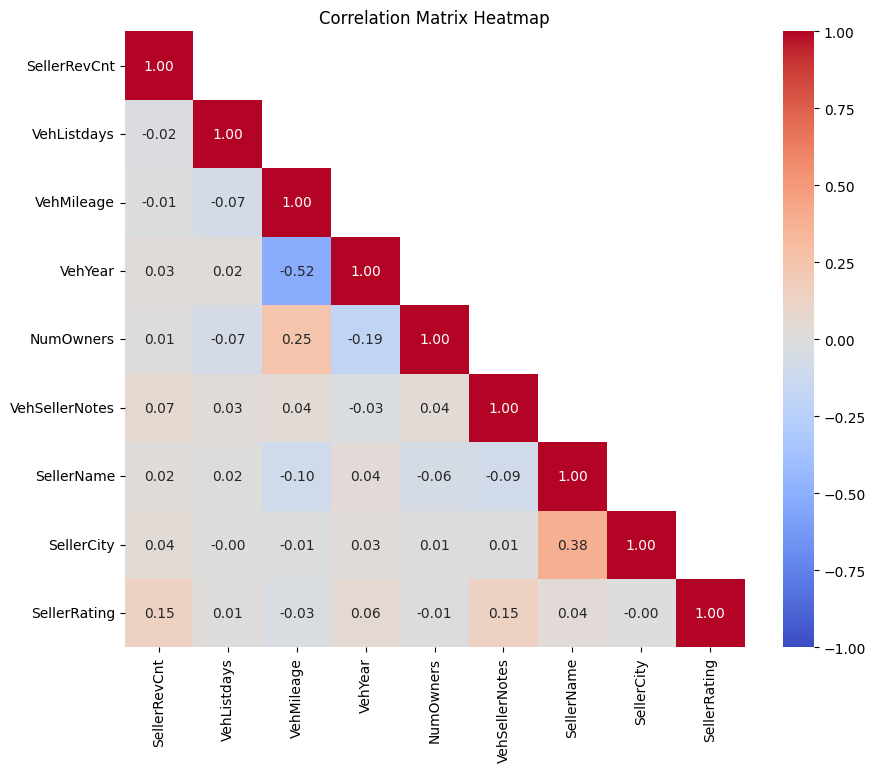

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
corrDF = X_train_nulls_raw[numerical_variables]

# Calculate correlation matrix
correlation = corrDF.corr()

# Set a threshold for highlighting correlations
threshold = 0.5

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation), k=1)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation, annot=True, cmap="coolwarm", mask=mask, fmt=".2f", vmin=-1, vmax=1
)
plt.title("Correlation Matrix Heatmap")
plt.show()

VehYear-VehMileage Pearson coeff is slighly underestimated from its Spearman analogue which is not surpising given that a curvilinear nature confuses P's (so to speak), and it underestimates the relationship’s strength. Seller Name-Seller city show a stronger though moderate linear dependence and so does VehMileage-NumOwners. These could possibly be explained by the fact that seller cities tend to have a set group of sellers therein and the more owners a vehicle has had, the greater its mileage. No further discussion will be made in regards to this measure as the variables were never normally distributed and outliers may greatly be impacting the magnitude of this statistic; this was more illustrative of an underestimate we could have relied on had we not considered the assumptions that showed Spearman's to be more fitting.


In [177]:
X_nulls = pd.concat([X_train_nulls_raw, X_test_nulls_raw])
X_nulls.shape

(7294, 24)

In [178]:
X_nulls.head()

,SellerCity,SellerIsPriv,SellerListSrc,SellerName,SellerRating,SellerRevCnt,SellerState,SellerZip,VehCertified,VehColorExt,...,VehFuel,VehHistory,VehListdays,VehMake,VehMileage,VehModel,VehPriceLabel,VehSellerNotes,VehYear,NumOwners
0,0.052857,False,inventorycommandcenter,0.030477,5.0,32,MI,48091,False,white,...,Gasoline,"['non-personal use reported', 'buyback protect...",8.600069,Jeep,39319.0,grandcherokee,fairprice,1.106467,2015,1.0
1,0.027835,False,cadillaccertifiedprogram,0.027051,4.8,1456,ND,58103,True,black,...,Gasoline,['buyback protection eligible'],2.920127,Cadillac,30352.0,xt5,gooddeal,3.26101,2017,1.0
2,0.04346,False,jeepcertifiedprogram,0.093138,4.8,1405,WI,53186,True,black,...,Gasoline,['buyback protection eligible'],28.107014,Jeep,38957.0,grandcherokee,gooddeal,4.770671,2015,1.0
3,0.047399,False,inventorycommandcenter,0.152806,4.4,21,MO,63385,False,black,...,Gasoline,"['non-personal use reported', 'buyback protect...",59.816875,Jeep,20404.0,grandcherokee,gooddeal,3.526611,2018,1.0
4,0.054436,False,homenetautomotive,0.031585,3.7,74,AR,72703,False,silver,...,Gasoline,"['non-personal use reported', 'buyback protect...",98.665301,Cadillac,19788.0,xt5,gooddeal,7.79934,2018,1.0


In [179]:
X_nulls.columns, len(X_nulls.columns)

(Index(['SellerCity', 'SellerIsPriv', 'SellerListSrc', 'SellerName',
        'SellerRating', 'SellerRevCnt', 'SellerState', 'SellerZip',
        'VehCertified', 'VehColorExt', 'VehColorInt', 'VehDriveTrain',
        'VehEngine', 'VehFeats', 'VehFuel', 'VehHistory', 'VehListdays',
        'VehMake', 'VehMileage', 'VehModel', 'VehPriceLabel', 'VehSellerNotes',
        'VehYear', 'NumOwners'],
       dtype='object'),
 24)

In [180]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    FunctionTransformer,
)

# Define column subsets
categorical_cols = [
    "SellerIsPriv",
    "SellerState",
    "SellerZip",
    "VehCertified",
    "VehColorExt",
    "VehColorInt",
    "VehFeats",
    "VehFuel",
    "VehHistory",
    "VehMake",
]
ordinal_cols = ["SellerRating", "VehPriceLabel"]
numeric_cols = [
    "SellerRevCnt",
    "VehListdays",
    "VehMileage",
    "VehYear",
    "NumOwners",
    "VehSellerNotes",
    "SellerName",
    "SellerCity",
]

# https://www.statology.org/dummy-variable-trap/
# NOTE We want to avoid running into the "dummy variable trap" which will intro collinearity in features that have binary
# output: SellerIsPriv, VehCertified, VehMake, VehModel (dropped later). Example: if jeep_VehModel is 0, then we know cadd_VehModel is 1 and make for linear dependence
# For k different variables, use k-1 dummy variables. Since these features are mutually exclusive we have to drop_first for each of them separately
# to the function
get_dummies_cols = ["SellerIsPriv", "VehCertified", "VehMake"]


# Custom transformer for get_dummies with drop_first=True
def get_dummies_transformer(X):
    return pd.get_dummies(X, columns=get_dummies_cols, drop_first=True)


dropMulticollinearity = FunctionTransformer(get_dummies_transformer, feature_names_out= 'one-to-one')

# Create transformers
categorical_transformer = Pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        ),
    ]
)

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler(with_mean=True)),
    ]  # https://stackoverflow.com/questions/52008548/python-running-into-x-test-y-test-fit-errors
)

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            categorical_transformer,
            [col for col in categorical_cols if col not in get_dummies_cols],
        ),
        ("get_dummies", dropMulticollinearity, get_dummies_cols), # custom step
        ("ord", ordinal_transformer, ordinal_cols),
        ("num", numeric_transformer, numeric_cols),
    ],
    remainder="drop",
)  # NOTE CRITICAL -- leave out the other features that showed multicollinearity w/other ft: VehModel, SellerListSrc, VehDriveTrain (had 401 null rows), VehEngine (had 361 null rows)


# Create a final pipeline with the preprocessor and any subsequent steps (e.g., a model)
final_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # Add additional steps as needed, e.g., a machine learning model -- holding off as we want to do imputation study
    ]
)
X = final_pipeline.fit_transform(X_nulls)
transformed_feature_names_X = final_pipeline.named_steps[
    "preprocessor"
].get_feature_names_out()

We now turn to the target variable in our train and notice there are nans in both columns. We replace nans in the dealer list price column with in-group averages should the matching trim be available from the other column. So, if there is a missing list price I will get the average for the car trim that had those list prices, if any, and vice versa.


In [181]:
y_train_nulls["Vehicle_Trim"].unique(), len(y_train_nulls["Vehicle_Trim"].unique())

(array(['High Altitude', nan, 'Laredo', 'Limited', 'Luxury', 'Limited 4x4',
        'Altitude', 'Overland', 'Premium Luxury', 'Base', 'Summit', 'FWD',
        'SRT', 'Luxury AWD', 'Trailhawk', 'Sterling Edition', 'Platinum',
        'Laredo E', 'Luxury FWD', 'Trackhawk', '75th Anniversary',
        'Premium Luxury FWD', 'Platinum AWD', 'SRT Night',
        'Limited 75th Anniversary Edition', '75th Anniversary Edition',
        'Limited 75th Anniversary', 'Premium Luxury AWD', 'Upland',
        'Limited X'], dtype=object),
 30)

In [182]:
priceLookup = y_train_nulls.groupby("Vehicle_Trim")["Dealer_Listing_Price"].median()
pd.DataFrame(priceLookup)

,Dealer_Listing_Price
Vehicle_Trim,
75th Anniversary,26737.0
75th Anniversary Edition,29430.0
Altitude,28774.0
Base,31000.0
FWD,26715.0
High Altitude,33599.0
Laredo,23035.0
Laredo E,29100.0
Limited,27896.0


In [183]:
trimLookup = y_train_nulls.groupby("Dealer_Listing_Price")["Vehicle_Trim"].agg(
    pd.Series.mode
)
pd.DataFrame(trimLookup)

,Vehicle_Trim
Dealer_Listing_Price,
18289.0,Laredo
18294.0,Laredo
18450.0,Laredo
18495.0,Limited
18698.0,Laredo
...,...
88000.0,Trackhawk
88950.0,Trackhawk
89452.0,Trackhawk


In [184]:
y_train_nulls["Vehicle_Trim"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 6294 entries, 0 to 6293
Series name: Vehicle_Trim
Non-Null Count  Dtype 
--------------  ----- 
5889 non-null   object
dtypes: object(1)
memory usage: 49.3+ KB


In [185]:
mia = y_train_nulls[y_train_nulls.isnull().any(axis=1)]
mia

,Dealer_Listing_Price,Vehicle_Trim
1,34860.0,NaN
20,41981.0,NaN
85,42921.0,NaN
132,44555.0,NaN
141,20746.0,NaN
...,...,...
6263,44960.0,NaN
6264,NaN,Luxury
6276,41891.0,NaN
6281,NaN,Luxury


In [186]:
y_train_nulls.iloc[282, :]

Dealer_Listing_Price    30998.0
Vehicle_Trim            Limited
Name: 282, dtype: object

In [187]:
defaultTrim = str(y_train_nulls.Vehicle_Trim.agg(pd.Series.mode)[0])
defaultPrice = y_train_nulls.Dealer_Listing_Price.median()
y_train = y_train_nulls.copy()

In [188]:
import math

# https://stackoverflow.com/questions/68671852/best-way-to-iterate-through-elements-of-pandas-series


# Function to find the first model trim within the given tolerance


def find_model_trim(knownPrice):
    # both trim and price are unknown (dreadful label) but have covariates
    # will end up with both defaults or, depending on tolerance, variation
    # with this default
    if math.isnan(knownPrice):
        return defaultTrim

    tolerance = 0.04  # 4% tolerance

    # Try to find comparable trim for that price within a tolerance
    for trim, price in zip(priceLookup.index, priceLookup.to_numpy()):
        if abs(knownPrice - price) / knownPrice <= tolerance:
            return trim

    return defaultTrim


def find_model_price(knownTrim):
    # both trim and price are unknown (dreadful label) but have covariates
    # will end up with both defaults or, depending on tolerance, variation
    # with this default

    if knownTrim != knownTrim:
        return defaultPrice

    # Find the median price for that trim
    priceFound = priceLookup.get(knownTrim, default=-1)
    priceNew = priceFound + 500

    if priceFound == -1:
        # trim may not be in the corpus being used, attempt to
        # find price for something slightly newer (more $)
        upgrade = trimLookup.get(priceNew, default=defaultPrice)
        priceFound = upgrade

    # may be the case that multiple cars at the border price share that price
    if isinstance(priceFound, (int, float)):
        return priceFound  # Return the number directly
    elif isinstance(priceFound, (list, np.ndarray)) and len(priceFound) > 0:
        return priceFound[0]  # Return the first element of the array


for index in y_train_nulls[y_train_nulls["Vehicle_Trim"].isnull()].index:
    y_train.loc[index, "Vehicle_Trim"] = find_model_trim(
        y_train_nulls.loc[index, "Dealer_Listing_Price"]
    )

# Populate nulls in y with group avgs and their corr labels
for index in y_train_nulls[y_train_nulls["Dealer_Listing_Price"].isnull()].index:
    y_train.loc[index, "Dealer_Listing_Price"] = find_model_price(
        y_train_nulls.loc[index, "Vehicle_Trim"]
    )

In [189]:
y_train.iloc[2061, :], y_train_nulls.iloc[2061, :]

(Dealer_Listing_Price       35530.0
 Vehicle_Trim            Luxury FWD
 Name: 2061, dtype: object,
 Dealer_Listing_Price           NaN
 Vehicle_Trim            Luxury FWD
 Name: 2061, dtype: object)

In [190]:
y_train[y_train["Vehicle_Trim"] == "Premium Luxury"]

,Dealer_Listing_Price,Vehicle_Trim
14,35830.0,Premium Luxury
21,34782.0,Premium Luxury
34,39995.0,Premium Luxury
52,35280.0,Premium Luxury
73,36888.0,Premium Luxury
...,...,...
6258,33994.0,Premium Luxury
6262,37680.0,Premium Luxury
6275,32000.0,Premium Luxury
6277,36045.0,Premium Luxury


In [191]:
# Define encoding for y. We won't scale the numeric values of target here but on Pytorch to go back and forth with 
# with the true label and labels used for train. Since std scaler uses mean 0 and dev 1 its easy to do
# for the OH encoding im not sure the scheme is used in pytorch like in sklearn so ill just
# map back the endoded ft names to the true label names
categorical_cols = [
    "Vehicle_Trim",
]
numeric_cols = [
    "Dealer_Listing_Price",
]

# Create transformers
categorical_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
    ],
	remainder= 'passthrough'
)

# Create a final pipeline with the preprocessor and any subsequent steps (e.g., a model)
final_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # Add additional steps as needed, e.g., a machine learning model -- holding off as we want to do imputation study
    ]
)
y = final_pipeline.fit_transform(
    y_train
)  # nothing is missing as nans were accounted for
transformed_feature_names_y = final_pipeline.named_steps[
    "preprocessor"
].get_feature_names_out()

A expected (without using imputation within the pipeline) we should see some NaN


In [192]:
np.any(np.isnan(X)), np.any(np.isnan(y))

(True, False)

In [193]:
X_train_nulls = X[: len(X_train_nulls_raw)]  # drop raw tag as now encoded
X_test_nulls = X[len(X_train_nulls_raw) :]
X_train_nulls.shape, X_test_nulls.shape

((6294, 3080), (1000, 3080))

In [194]:
np.any(np.isnan(X_train_nulls))

True

Now that we have encoded the data let's take a look at the distributions (before the compression from encoding)


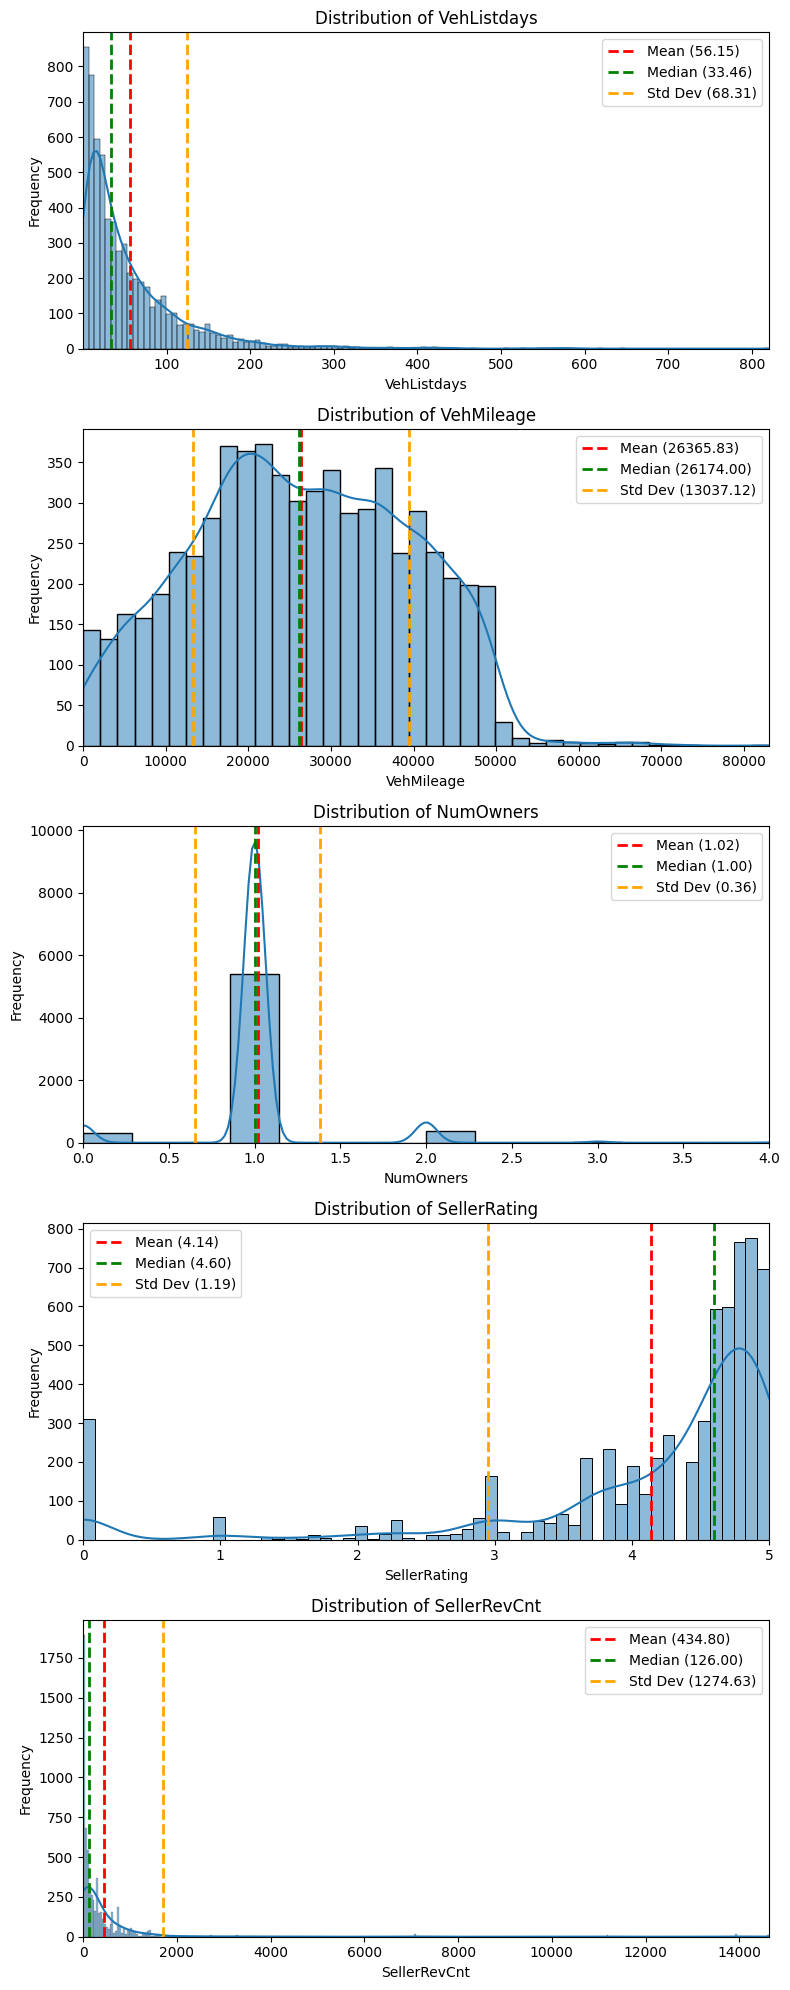

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt

distCol = [
    "VehListdays",
    "VehMileage",
    "NumOwners",
    "SellerRating",
    "SellerRevCnt",
]
# Set up subplots -- NOTE: Dealer_Listing_Price is part of what we want to predict!
fig, axes = plt.subplots(nrows=len(distCol), ncols=1, figsize=(8, 4 * len(distCol)))

## Plot distribution and statistics for each column
for i, column in enumerate(distCol):
    # Plot distribution
    sns.histplot(X_train_nulls_raw[column], kde=True, ax=axes[i])

    # Calculate statistics
    mean_value = X_train_nulls_raw[column].mean()
    median_value = X_train_nulls_raw[column].median()
    std_dev_value = X_train_nulls_raw[column].std()

    # Plot major statistics below the distribution plot
    axes[i].axvline(
        mean_value,
        color="red",
        linestyle="dashed",
        linewidth=2,
        label=f"Mean ({mean_value:.2f})",
    )
    axes[i].axvline(
        median_value,
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Median ({median_value:.2f})",
    )
    axes[i].axvline(
        mean_value + std_dev_value,
        color="orange",
        linestyle="dashed",
        linewidth=2,
        label=f"Std Dev ({std_dev_value:.2f})",
    )
    axes[i].axvline(
        mean_value - std_dev_value, color="orange", linestyle="dashed", linewidth=2
    )
    axes[i].legend()

    # Set x-axis limits to the minimum and maximum values of the distribution
    axes[i].set_xlim(X_train_nulls_raw[column].min(), X_train_nulls_raw[column].max())

    # Set plot labels and title
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Distribution of {column}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

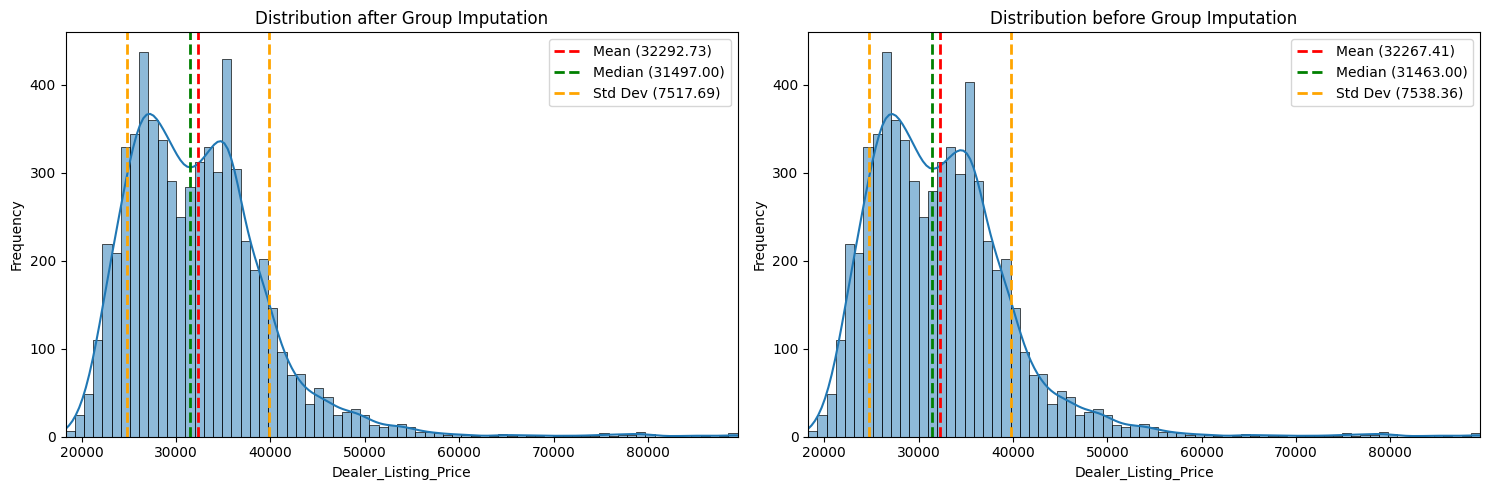

In [196]:
# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot distribution after group imputation
sns.histplot(y_train["Dealer_Listing_Price"], kde=True, ax=axes[0])

# Calculate statistics after group imputation
mean_value_after = y_train["Dealer_Listing_Price"].mean()
median_value_after = y_train["Dealer_Listing_Price"].median()
std_dev_value_after = y_train["Dealer_Listing_Price"].std()

# Plot major statistics after group imputation
axes[0].axvline(
    mean_value_after,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean ({mean_value_after:.2f})",
)
axes[0].axvline(
    median_value_after,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Median ({median_value_after:.2f})",
)
axes[0].axvline(
    mean_value_after + std_dev_value_after,
    color="orange",
    linestyle="dashed",
    linewidth=2,
    label=f"Std Dev ({std_dev_value_after:.2f})",
)
axes[0].axvline(
    mean_value_after - std_dev_value_after,
    color="orange",
    linestyle="dashed",
    linewidth=2,
)
axes[0].legend()

# Set x-axis limits to the minimum and maximum values of the distribution
axes[0].set_xlim(
    y_train["Dealer_Listing_Price"].min(),
    y_train["Dealer_Listing_Price"].max(),
)

# Set plot labels and title for the first subplot
axes[0].set_xlabel("Dealer_Listing_Price")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution after Group Imputation")

# Plot distribution before group imputation using y_train_nulls
sns.histplot(y_train_nulls["Dealer_Listing_Price"], kde=True, ax=axes[1])

# Calculate statistics before group imputation
mean_value_before = y_train_nulls["Dealer_Listing_Price"].mean()
median_value_before = y_train_nulls["Dealer_Listing_Price"].median()
std_dev_value_before = y_train_nulls["Dealer_Listing_Price"].std()

# Plot major statistics before group imputation
axes[1].axvline(
    mean_value_before,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean ({mean_value_before:.2f})",
)
axes[1].axvline(
    median_value_before,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Median ({median_value_before:.2f})",
)
axes[1].axvline(
    mean_value_before + std_dev_value_before,
    color="orange",
    linestyle="dashed",
    linewidth=2,
    label=f"Std Dev ({std_dev_value_before:.2f})",
)
axes[1].axvline(
    mean_value_before - std_dev_value_before,
    color="orange",
    linestyle="dashed",
    linewidth=2,
)
axes[1].legend()

# Set x-axis limits to the minimum and maximum values of the distribution
axes[1].set_xlim(
    y_train_nulls["Dealer_Listing_Price"].min(),
    y_train_nulls["Dealer_Listing_Price"].max(),
)

# Set plot labels and title for the second subplot
axes[1].set_xlabel("Dealer_Listing_Price")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution before Group Imputation")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

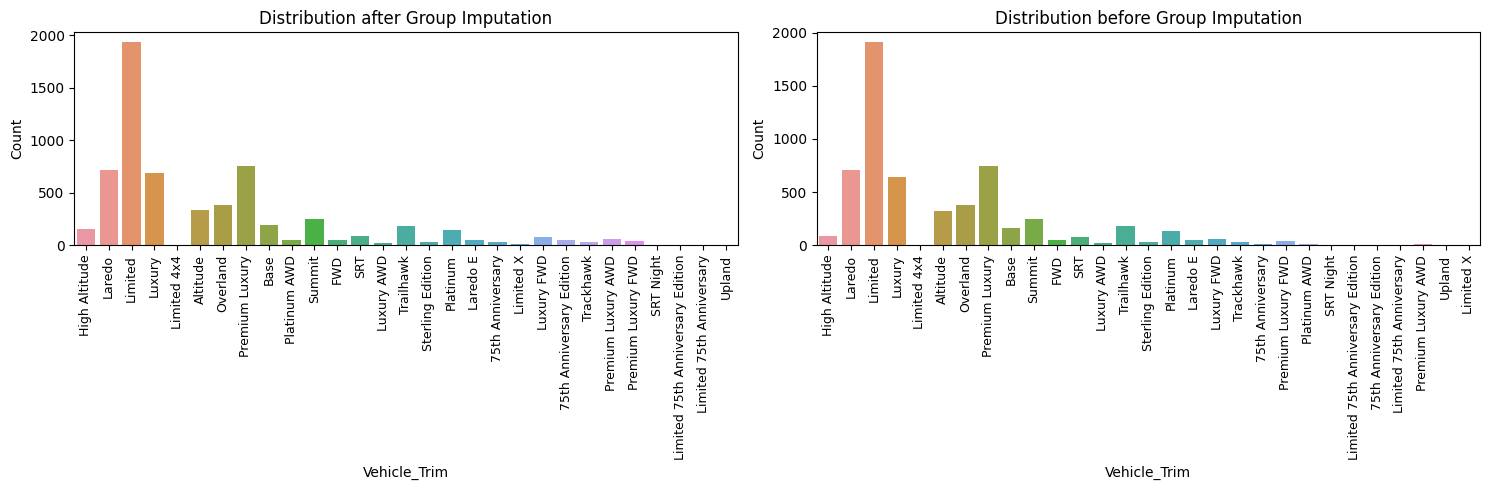

In [197]:
# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot counts after group imputation
sns.countplot(x=y_train["Vehicle_Trim"], ax=axes[0])
axes[0].tick_params(axis="x", rotation=90, labelsize=9)  # Rotate and adjust label size

# Set plot labels and title for the first subplot
axes[0].set_xlabel("Vehicle_Trim")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution after Group Imputation")

# Plot counts before group imputation using y_train_nulls
sns.countplot(x=y_train_nulls["Vehicle_Trim"], ax=axes[1])
axes[1].tick_params(axis="x", rotation=90, labelsize=9)  # Rotate and adjust label size

# Set plot labels and title for the second subplot
axes[1].set_xlabel("Vehicle_Trim")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution before Group Imputation")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

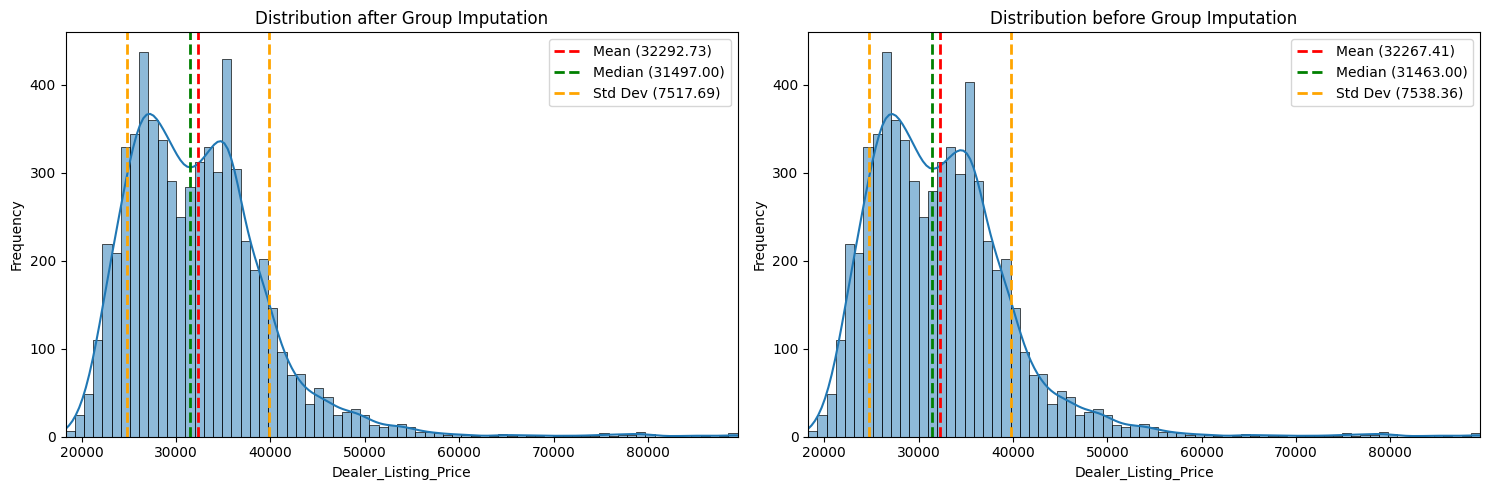

In [198]:
# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot distribution after group imputation
sns.histplot(y_train["Dealer_Listing_Price"], kde=True, ax=axes[0])

# Calculate statistics after group imputation
mean_value_after = y_train["Dealer_Listing_Price"].mean()
median_value_after = y_train["Dealer_Listing_Price"].median()
std_dev_value_after = y_train["Dealer_Listing_Price"].std()

# Plot major statistics after group imputation
axes[0].axvline(
    mean_value_after,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean ({mean_value_after:.2f})",
)
axes[0].axvline(
    median_value_after,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Median ({median_value_after:.2f})",
)
axes[0].axvline(
    mean_value_after + std_dev_value_after,
    color="orange",
    linestyle="dashed",
    linewidth=2,
    label=f"Std Dev ({std_dev_value_after:.2f})",
)
axes[0].axvline(
    mean_value_after - std_dev_value_after,
    color="orange",
    linestyle="dashed",
    linewidth=2,
)
axes[0].legend()

# Set x-axis limits to the minimum and maximum values of the distribution
axes[0].set_xlim(
    y_train["Dealer_Listing_Price"].min(),
    y_train["Dealer_Listing_Price"].max(),
)

# Set plot labels and title for the first subplot
axes[0].set_xlabel("Dealer_Listing_Price")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution after Group Imputation")

# Plot distribution before group imputation using y_train_nulls
sns.histplot(y_train_nulls["Dealer_Listing_Price"], kde=True, ax=axes[1])

# Calculate statistics before group imputation
mean_value_before = y_train_nulls["Dealer_Listing_Price"].mean()
median_value_before = y_train_nulls["Dealer_Listing_Price"].median()
std_dev_value_before = y_train_nulls["Dealer_Listing_Price"].std()

# Plot major statistics before group imputation
axes[1].axvline(
    mean_value_before,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean ({mean_value_before:.2f})",
)
axes[1].axvline(
    median_value_before,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Median ({median_value_before:.2f})",
)
axes[1].axvline(
    mean_value_before + std_dev_value_before,
    color="orange",
    linestyle="dashed",
    linewidth=2,
    label=f"Std Dev ({std_dev_value_before:.2f})",
)
axes[1].axvline(
    mean_value_before - std_dev_value_before,
    color="orange",
    linestyle="dashed",
    linewidth=2,
)
axes[1].legend()

# Set x-axis limits to the minimum and maximum values of the distribution
axes[1].set_xlim(
    y_train_nulls["Dealer_Listing_Price"].min(),
    y_train_nulls["Dealer_Listing_Price"].max(),
)

# Set plot labels and title for the second subplot
axes[1].set_xlabel("Dealer_Listing_Price")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution before Group Imputation")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

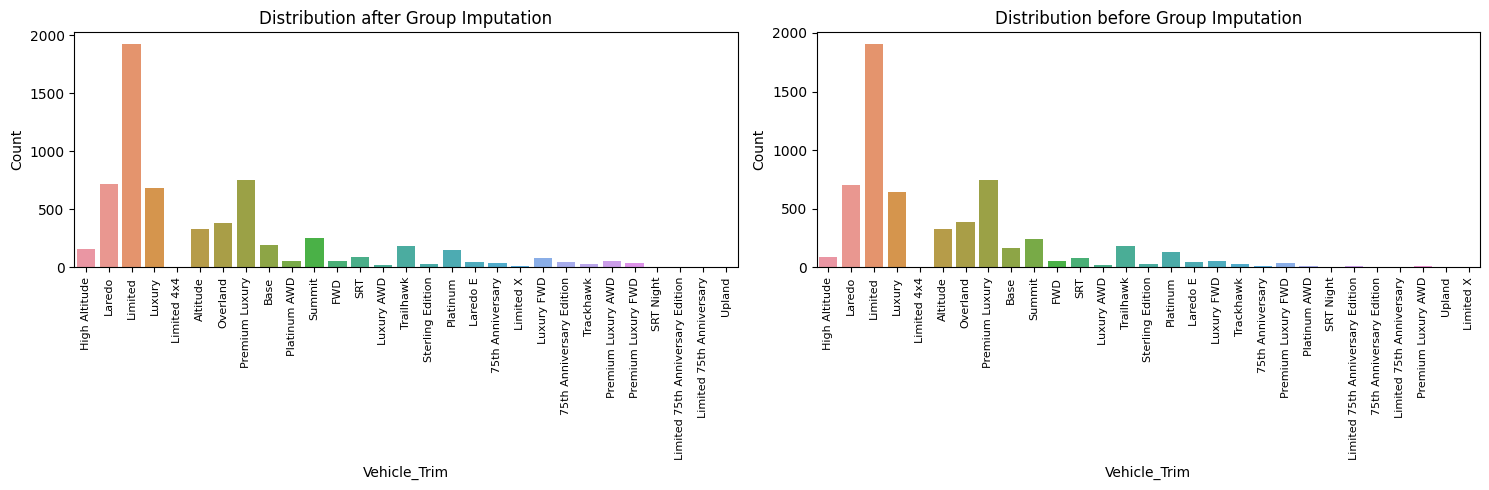

In [199]:
# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot counts after group imputation
sns.countplot(x=y_train["Vehicle_Trim"], ax=axes[0])
axes[0].tick_params(axis="x", rotation=90, labelsize=8)  # Rotate and adjust label size

# Set plot labels and title for the first subplot
axes[0].set_xlabel("Vehicle_Trim")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution after Group Imputation")

# Plot counts before group imputation using y_train_nulls
sns.countplot(x=y_train_nulls["Vehicle_Trim"], ax=axes[1])
axes[1].tick_params(axis="x", rotation=90, labelsize=8)  # Rotate and adjust label size

# Set plot labels and title for the second subplot
axes[1].set_xlabel("Vehicle_Trim")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution before Group Imputation")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

None of the data distributions look Gaussian but standard scaling was used as it will not change the shape of the distribution.

https://stats.stackexchange.com/questions/453211/using-standardscaler-function-of-scikit-learn-library
https://stats.stackexchange.com/questions/290958/logistic-regression-and-scaling-of-features


Forgetting something? Yes, null values and outliers. Extensive outlier consideration will be omitted here due to time and knowing that logistic regression is kinder to us in this regard due to log-odds considerations. The standard scaler also blunted some of this effect in theory. As for imputation we will see which method would be best used to cover nan values comparing against various baseline for permuting holes in the data.

https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py


The general idea for imputation here is to see if there are massive swings in MSE when we impute the dataset going from one strategy to another. We shall use a modified set of matrices, dropping rows of X containing any nan and calling it a fully populated matrix alongside its target y. We then inflate this matrix with nans and assess impacts going from one strategy of imputation to another using the baseline RF regressor.


In [200]:
np.any(np.isnan(X_train_nulls)), np.any(np.isnan(y))

(True, False)

In [201]:
# Create a random number generator
rng = np.random.RandomState(42)

nan_rows_mask = np.any(np.isnan(X_train_nulls), axis=1)

# Extract indices of rows with NaN values
nan_rows_indices = np.where(nan_rows_mask)[0]

# Drop rows with NaN values. There are artificially clean matrices for data (representing an abrasive dropping of all NaN entries
# that introduce all hosts of problems if relied on as a defacto solution to handling missing data) we use it as a template
# here to compare against imputation strategies
X_full = X_train_nulls[~nan_rows_mask]
y_full = y[~nan_rows_mask]


def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 50% of the lines
    missing_rate = 0.5
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[:n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing


X_missing, y_missing = add_missing_values(X_full, y_full)

print(f"X_full nans -> {np.any(np.isnan(X_full))}")
print(f"X_missing nans -> {np.any(np.isnan(X_missing))}")

X_full nans -> False
X_missing nans -> True


In [202]:
# placeholder clean as we dont have access to a clean baseline fill with medians
# X_full = np.where(
#    np.isnan(X_train_nulls),  # Condition: True where X_train_nulls is NaN
#    np.nanmedian(
#        X_train_nulls, axis=0
#    ),  # Value to replace NaN with (column-wise median)
#    X_train_nulls,  # Original values where condition is False
# )

In [203]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# https://machinelearningmastery.com/multi-output-regression-models-with-python/

# Set random seed for reproducibility
np.random.seed(0)

# previously tuned on X_full
base_estimators = {
    "Random Forest": RandomForestRegressor(n_jobs=-1),
}

N_SPLITS = 5

# Define imputation methods
imputation_methods = {
    "Full Data": None,
    "Zero Imputation": SimpleImputer(
        missing_values=np.nan, add_indicator=True, strategy="constant", fill_value=0
    ),
    "5-KNN Imputation": KNNImputer(
        missing_values=np.nan, add_indicator=True, n_neighbors=5
    ),
    "15-KNN Imputation": KNNImputer(
        missing_values=np.nan, add_indicator=True, n_neighbors=15
    ),
    "Mean Imputation": SimpleImputer(
        missing_values=np.nan, strategy="mean", add_indicator=True
    ),
    "Median Imputation": SimpleImputer(
        missing_values=np.nan, strategy="median", add_indicator=True
    ),
}

# Evaluate each imputation method
mses_car = {}
stds_car = {}
x_labels = []

for name, imputer in imputation_methods.items():
    for est_name, base_estimator in base_estimators.items():
        pipeline_steps = [("base_estimator", base_estimator)]

        if imputer:
            pipeline_steps.insert(0, ("imputer", imputer))

        pipeline = Pipeline(pipeline_steps)

        key = f"{name} - {est_name}"
        print(key)

        impute_scores = cross_val_score(
            pipeline,
            X_full if name == "Full Data" else X_missing,
            y_full if name == "Full Data" else y_missing,
            scoring="neg_mean_squared_error",
            cv=N_SPLITS,
        )

        mses_car[key] = -impute_scores.mean()
        stds_car[key] = impute_scores.std()
        x_labels.append(key)

# Convert to numpy arrays for plotting
mses_car = np.array(list(mses_car.values()))
stds_car = np.array(list(stds_car.values()))

Full Data - Random Forest
Zero Imputation - Random Forest
5-KNN Imputation - Random Forest
15-KNN Imputation - Random Forest


KeyboardInterrupt: 

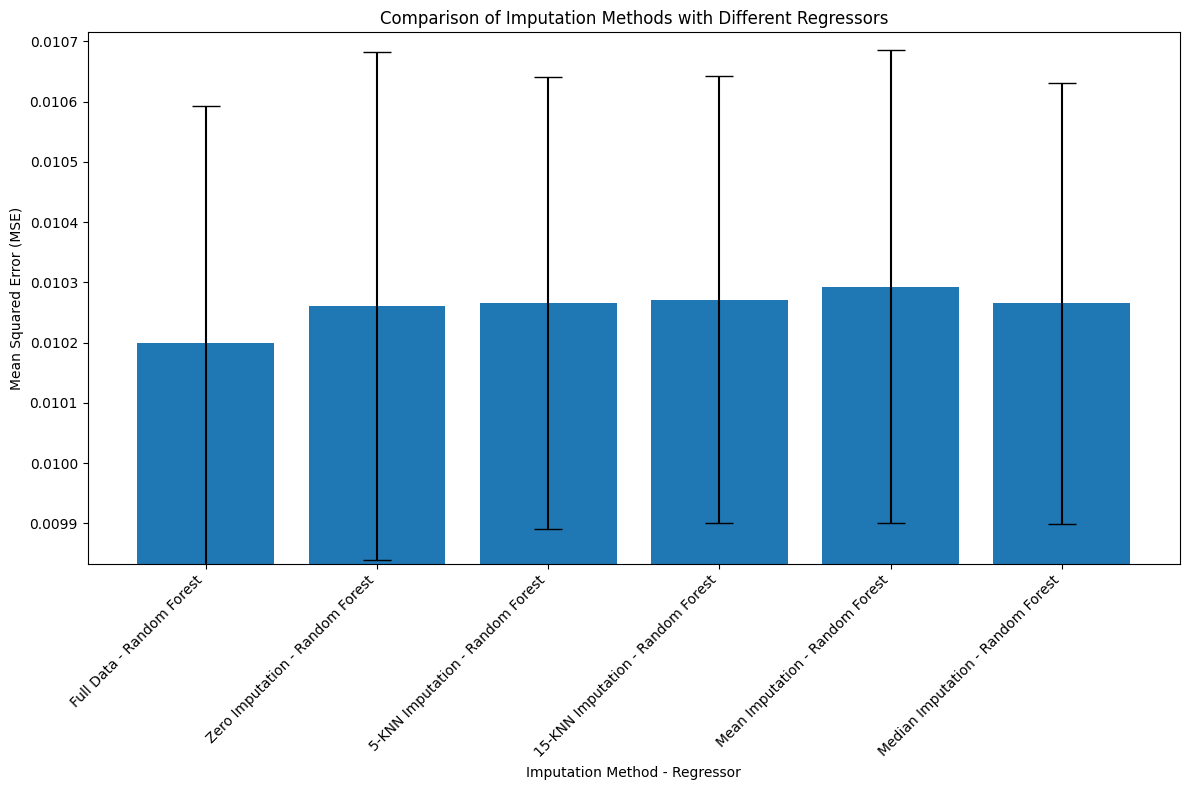

In [ ]:
# Plotting MSEs with error bars (standard deviations)
plt.figure(figsize=(12, 8))

# Calculate the min and max values of MSEs plus/minus one standard deviation
min_mse = np.min(min(mses_car) - min(stds_car))
max_mse = np.max(max(mses_car) + max(stds_car))

# Plotting adjusted MSEs with error bars (standard deviations)
bars = plt.bar(x_labels, mses_car, yerr=stds_car, capsize=10)

plt.title("Comparison of Imputation Methods with Different Regressors")
plt.xlabel("Imputation Method - Regressor")
plt.ylabel("Mean Squared Error (MSE)")

# Adjust the y-axis limits
plt.ylim(min_mse, max_mse)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.tight_layout()
plt.show()

If you observe a Mean Squared Error (MSE) that is very close to 0 even after applying several methods of imputation in a regression task, the model may be overfitting the training data, capturing noise or specific patterns that don't generalize well to new, unseen data or the target variable may be perfectly predictable from the features, leading to very low error. I suspect the latter, where we saw that several features had close association and were almost perfectly predictable: a Jeep-grandcherokee, Caddy-xt5, 50k+mileage-year below 2020, for example.

In each such case we narrow the window of which trim is available at which price range by combining one or two of these sets even upon inspection! It's also important to note that we "only" lost about 5% of the rows from our original frame when creating `X_full` (essentailly what would happen if we dropped any row with nan entry) -- which may have not impacted the data as aggresively just by its volume (but that could otherwise have contained rare relationships that wouldve been lost) This is where association rules mining may be the simplest model, though it will not capture nuanced complexity as well as the logistic regression model we opt for. This model will be a 'no-fuss' candidate that will be much more interpretable than other algos out there.

Some possible cures would be to rely on regularization techniques, simplification of the feature space, or tuning hyperparams. As for the secon point, we partly addressed by dropping certain features. Hyperparameter tuning will be done in the next segment. As all our imputation strategies show little significant difference from one another we'll use group median imputation to mask nans before modeling.


In [ ]:
X_train_nulls[np.isnan(X_train_nulls)] = np.nanmedian(X_train_nulls)
X_test_nulls[np.isnan(X_test_nulls)] = np.nanmedian(X_test_nulls)

In [ ]:
np.isnan(X_train_nulls).any(), np.isnan(y).any(), np.isnan(X_test_nulls).any()

(False, False, False)

In [ ]:
np.savetxt("../data/py_training_X.csv", X_train_nulls, delimiter=",")

In [ ]:
np.savetxt("../data/py_test_X.csv", X_test_nulls, delimiter=",")

In [ ]:
np.savetxt("../data/py_test_id.csv", y_test_id_nulls_raw, delimiter=",")

In [ ]:
np.savetxt(
    "../data/py_y_enc_ft_names.csv",
    transformed_feature_names_y,
    delimiter=",",
    fmt="%s",
)
np.savetxt(
    "../data/py_X_ft_names.csv",
    list(X_train_nulls_raw.columns),
    delimiter=",",
    fmt="%s",
)

np.savetxt(
    "../data/py_y_train.csv", y_train, delimiter=",", fmt="%s"
)
np.savetxt(
    "../data/py_y_enc_train.csv", y, delimiter=",", fmt="%s"
)

